# Processing TROPESS (PAN)

James Yoon 

Last updated: 15 January 2024

---

This notebook reads in PAN (derived from TROPESS). You can then take the PAN retrievals and interpolate them onto your desired grid.

The dataset can be found on Earthdata as TROPESS CrIS-SNPP L2 Peroxyacetyl Nitrate for Reanalysis Stream, Summary Product V1 (TRPSYL2PANCRSRS) at GES DISC.

The user guide to the data can be found [here](https://docserver.gesdisc.eosdis.nasa.gov/public/project/TROPESS/User_Guides/TROPESS-CRIS-PAN_L2_Product_Quick_Start_User_Guide_Standard_only_2-22-21.pdf).

In [22]:
# Common imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob
from datetime import timedelta

# More uncommon imports -- make sure you have satellite_processing_functions.py in the same directory
import netCDF4 as nc
import geopandas as gpd
import shapely
# import xesmf as xe

# Mapping functions -- not required to process the data, but nice to plot as a sanity check!
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%config InlineBackend.figure_format='retina'
plt.rcParams["font.family"] = "Arial"

def basemap():
    # Creates a fig and ax object with a map of the globe using the Cartopy library
    fig = plt.figure(figsize=(10,5));
    ax = fig.add_subplot(111, projection=ccrs.Robinson()); # Can change the projection using different ccrs.__()
    color = 'gray' # Color of the map lines

    # Add in the coastlines, states, and country borders with 50 m resolution.
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.5, edgecolor = color);
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor = color);
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.5, edgecolor = color);

    return fig, ax;

# Parameters

In [3]:
averaging_kernel = False; # True if you want averaging kernel and altitude information, false otherwise.

In [26]:
files = glob('/home/disk/hermes/jyyoon/TROPESS/PAN_L2/TROPESS_CrIS-SNPP_L2_Summary_PAN*.nc')

ds = pd.DataFrame() # Will contain the final dataset

# Loop through the files
for fn in files[1:10]:
    data = xr.open_dataset(fn)
    time = data.RangeBeginningDate

    if averaging_kernel:
        df = data[['time', 'year_fraction', 'pressure', 'target_id', 'x_col_ft', 'x_col_ft_error', 'xa_col_ft', 'ak_x_col_ft', 'air_frac_col_ft', 'h2o_col', 'h2o_quality']].to_dataframe()
    else:
        df = data[['time', 'year_fraction', 'target_id', 'x_col_ft', 'x_col_ft_error', 'air_frac_col_ft', 'h2o_col', 'h2o_quality']].to_dataframe()
    data.close() 
    
    # Quality checks
    df = df.where(df.h2o_quality == 1) # Check water column retrieval quality
    df = df.where(df.x_col_ft > -999)
    df['time'] = time;
    df = df.dropna(subset = ['x_col_ft'], axis = 0)

    ds = pd.concat([ds, df])

# Bias correction -- see user manual
ds['x_bias'] = -0.07 - (0.10 * 1.0e-23 * ds.h2o_col)
ds['x_bias_corrected'] =  ds['x_col_ft'] - ds['x_bias']

Text(0.5, 1.0, 'PAN from SNPP')

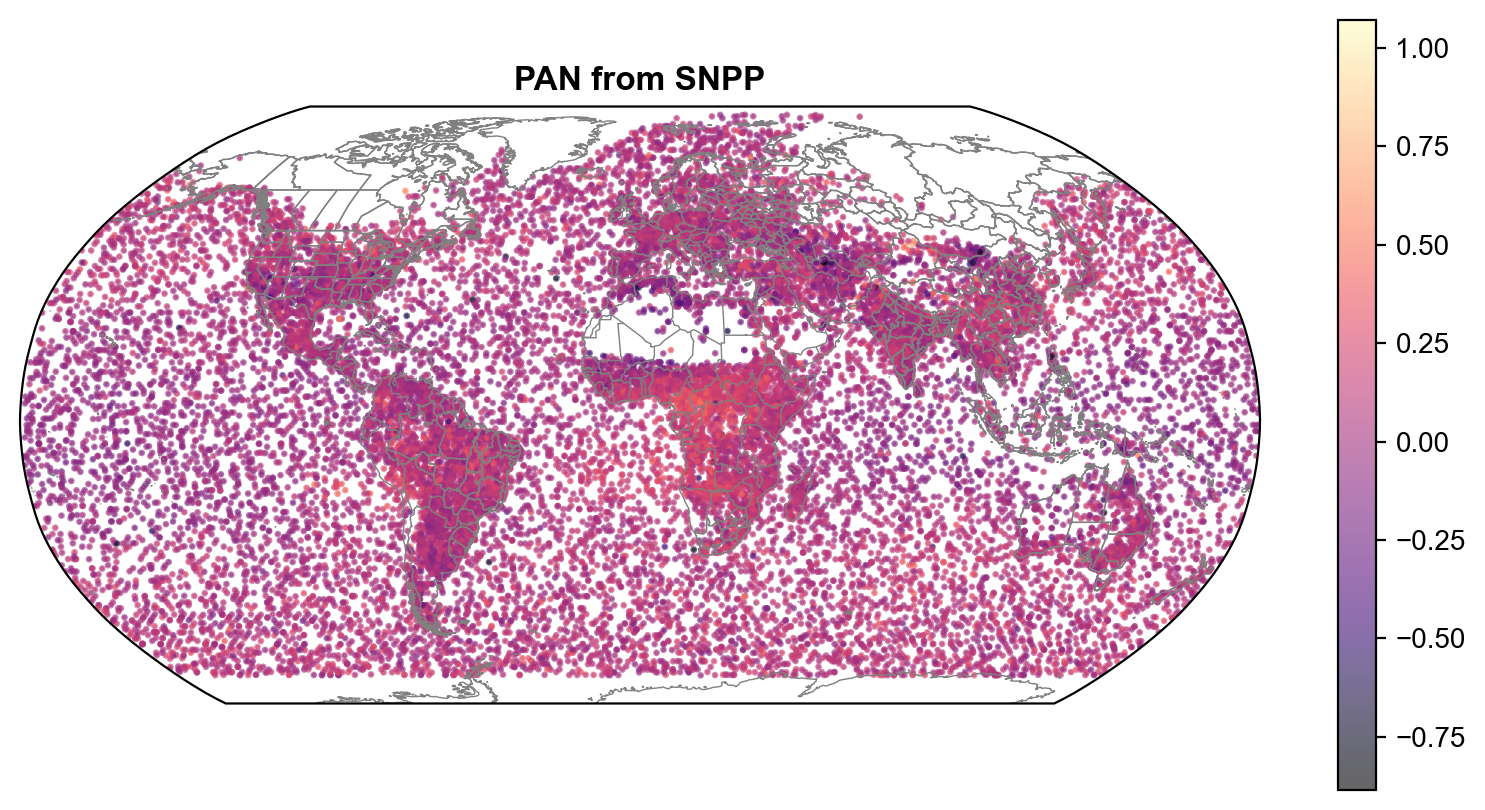

In [29]:
fig, ax = basemap()

im = ax.scatter(ds.longitude, ds.latitude, c = ds.x_bias_corrected, s = 2, cmap = 'magma', transform = ccrs.PlateCarree(), alpha = 0.6)
fig.colorbar(im)
ax.set_title("PAN from SNPP", weight = "bold")